# Dependencies

In [1]:
using CSV, DataFrames, Random

In [2]:
using Flux

In [3]:
using CUDA

In [4]:
using Plots

# Data loading

In [5]:
function splitdf(df, pct)
   @assert 0 <= pct <= 1
   ids = collect(axes(df, 1))
   shuffle!(ids)
   sel = ids .<= nrow(df) .* pct
   return view(df, sel, :), view(df, .!sel, :)
end;

In [6]:
df = "fashion-mnist_train.csv" |> CSV.File |> DataFrame;
df_train, df_valid = splitdf(df, 0.666)
df_test = "fashion-mnist_test.csv" |> CSV.File |> DataFrame;

In [7]:
labels = Dict(
    0 => "T-shirt",
    1 => "Trouser",
    2 => "Pullover",
    3 => "Dress",
    4 => "Coat",
    5 => "Sandal",
    6 => "Shirt",
    7 => "Sneaker",
    8 => "Bag",
    9 => "Ankle boot"
);

In [8]:
function load_y(df)
    y = df[:, :label]
    Flux.onehotbatch(y, 0:9)
end

y_train = load_y(df_train) |> y -> Flux.label_smoothing(y, 0.2f0) |> gpu
y_valid = load_y(df_valid) |> gpu;
y_test= load_y(df_test) |> gpu;

In [9]:
function load_x(df)
    x = select(df, Not(:label)) |> Matrix |> permutedims
    x = reshape(x, 28, 28, 1, :) / 255
    convert(Array{Float32,4}, x) |> m -> permutedims(m, (2,1,3,4))
end

x_train = load_x(df_train) |> gpu
x_valid = load_x(df_valid) |> gpu;
x_test = load_x(df_test) |> gpu;

# Custom training function

In [10]:
function train!(loss, ps, data, opt)
	local training_loss
	for d in data
    	gs = gradient(ps) do
      		training_loss = loss(d...)
      		return training_loss
		end
    # Insert whatever code you want here that needs training_loss, e.g. logging.
    # E.g. logging with TensorBoardLogger.jl as histogram so you can see if it is becoming huge.
    Flux.update!(opt, ps, gs)
    # Here you might like to check validation set accuracy, and break out to do early stopping.
	end
    training_loss
end;

# CNN

In [35]:
predict(x) = labels[Flux.onecold(model(cat(x; dims=4)), 0:9)[1]]
get_label(y) = labels[Flux.onecold(y, 0:9)[1]]

function acc(x, y) 
    ŷ = model(x) |> Flux.onecold
    cy = y |> Flux.onecold
    sum(ŷ .== cy) / length(cy)
end;

In [36]:
model = Chain(
    Conv((3, 3), 1 => 32, relu)
    , AdaptiveMaxPool((14, 14))
    , Conv((3, 3), 32 => 32, relu)
    , Flux.Dropout(0.2)
    , Flux.flatten
    , Dense(4608, 32, relu)
    , Dense(32, 10)
    , softmax
) |> gpu

ps = params(model)

loss(x, y) = Flux.mse(model(x), y)

opt = ADAM()

data = Flux.DataLoader((x_train, y_train), batchsize=512, shuffle=true) |> gpu;

229.065958 seconds (24.68 M allocations: 2.133 GiB, 1.97% gc time, 0.04% compilation time)


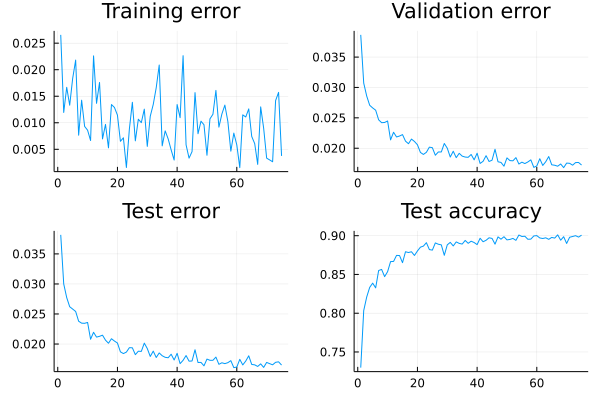

In [37]:
tre = []
vde = []
tse = []
ats = []
@time for epoch=1:75
	push!(tre, train!(loss, ps, data, opt))
	push!(vde, loss(x_valid, y_valid))
	push!(tse, loss(x_test, y_test))
	push!(ats, acc(x_test, y_test))
end
plot(
    plot(tre, title="Training error")
    , plot(vde, title="Validation error")
    , plot(tse, title="Test error")
    , plot(ats, title="Test accuracy")
    , legend = false
)

In [38]:
acc(x_test, y_test)

0.9007

## Evaluation

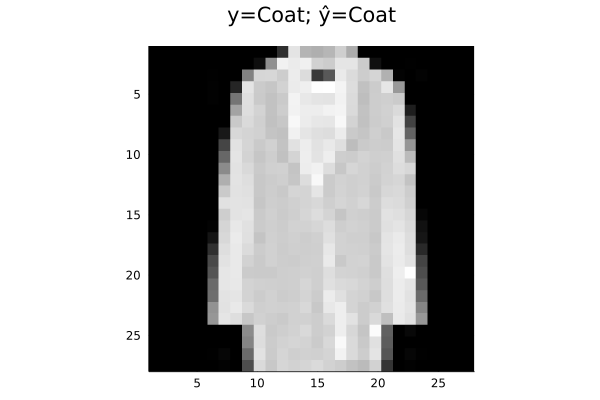

In [45]:
idx = 21
xi = x_test[:, :, 1, idx]
ŷi = xi |> predict
yi = y_test[:, idx] |> get_label
plot(Gray.(xi), title="y=$(yi); ŷ=$ŷi\n")

# Autoencoder

In [16]:
x_train_autoenc = select(df_train, Not(:label)) |> Matrix |> permutedims |> m -> convert(Matrix{Float32}, m / 255) |> gpu;

In [17]:
x_test_autoenc = select(df_test, Not(:label)) |> Matrix |> permutedims |> m -> convert(Matrix{Float32}, m / 255) |> gpu;

## Compression and decompression

In [18]:
enc = Chain(
    Dense(784, 1024, relu)
    , Dense(1024, 256, relu)
    , Dense(256, 16, relu)
) |> gpu

knw = Chain(
    Dense(16, 16, σ)
) |> gpu

dec = Chain(
    Dense(16, 256, relu)
    , Dense(256, 1024, relu)
    , Dense(1024, 784, relu)
) |> gpu

auto = Chain(
    enc
    , knw
    , dec
) |> gpu;

## Classification

In [19]:
clf = Chain(
    Dense(16, 32, relu)
    , Dense(32, 10)
    , softmax
) |> gpu

m2 = Chain(
    enc
    , knw
    , clf
) |> gpu;

In [20]:
data_autoenc = Flux.DataLoader((x_train_autoenc, x_train_autoenc), batchsize=1024, shuffle=true) |> gpu;

In [21]:
loss_autoenc(x, y) = Flux.mse(auto(x), y)

loss_autoenc (generic function with 1 method)

In [22]:
h = []
@time for e=1:200
    push!(h, train!(loss_autoenc, params(auto), data_autoenc, ADAM()))
end;

 81.822052 seconds (46.18 M allocations: 3.034 GiB, 2.30% gc time, 3.10% compilation time)


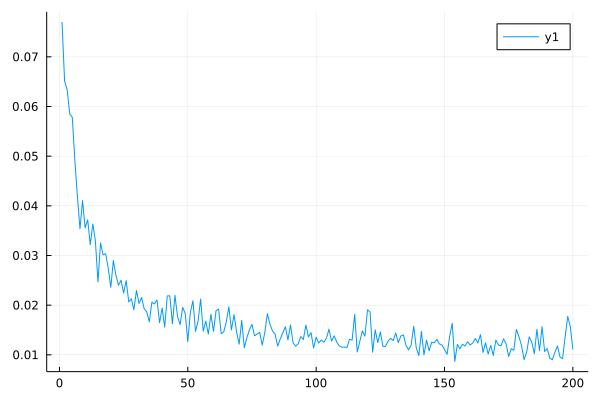

In [23]:
plot(h)

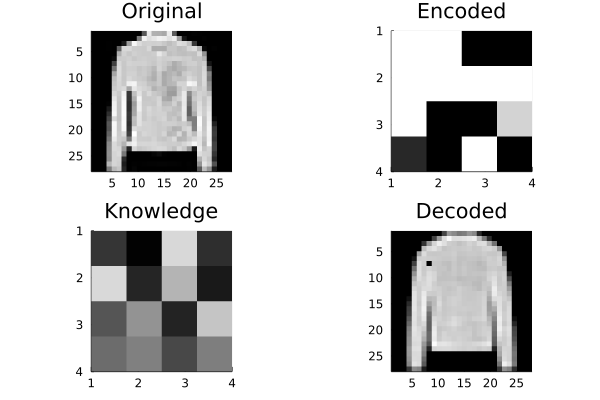

In [24]:
og = x_test_autoenc[:, 97]
en = enc(og)
kn = knw(en)
dc = dec(kn)
plot(
    plot(
        Gray.(reshape(og, 28, 28)'), title="Original"
    ),
    plot(
        Gray.(reshape(en, 4, 4)'), title="Encoded"
    ),
    plot(
        Gray.(reshape(kn, 4, 4)'), title="Knowledge"
    ),
    plot(
        Gray.(reshape(dc, 28, 28)'), title="Decoded"
    )
)

In [25]:
data_autoenc_classif = Flux.DataLoader((knw(enc(x_train_autoenc)), y_train), batchsize=1024, shuffle=true) |> gpu;

In [26]:
loss_autoenc_classif(x, y) = Flux.mse(clf(x), y)

loss_autoenc_classif (generic function with 1 method)

In [27]:
hc = []
@time for e=1:200
    push!(hc, train!(loss_autoenc_classif, params(clf), data_autoenc_classif, ADAM()))
end;

  5.830112 seconds (13.64 M allocations: 920.386 MiB, 3.81% gc time, 6.80% compilation time)


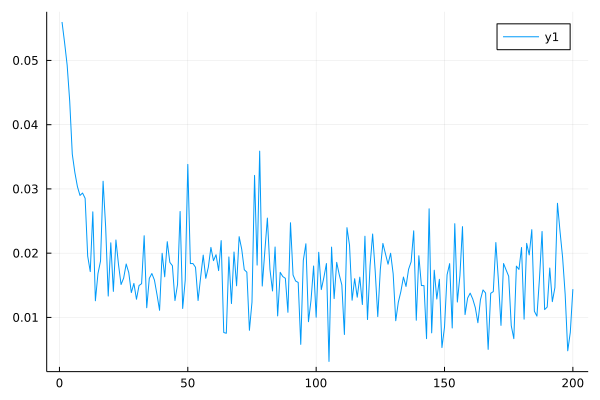

In [28]:
hc |> plot

## Evaluation

In [29]:
compressed_x = x_test_autoenc |> enc |> knw

16×10000 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0964515  0.687433   0.38935   …  0.0229567  0.0828075  0.0275287
 0.0842856  0.256297   0.128479     0.313112   0.0683249  0.0963836
 0.923822   0.112669   0.734942     0.317046   0.883354   0.823943
 0.440086   0.0288068  0.279409     0.54377    0.58625    0.652996
 0.245017   0.887243   0.632832     0.271099   0.682728   0.72516
 0.465571   0.791548   0.190095  …  0.784784   0.0578412  0.298009
 0.398822   0.162333   0.438307     0.453514   0.243272   0.53921
 0.174767   0.130043   0.432836     0.158041   0.118806   0.0655578
 0.378365   0.411254   0.439981     0.344356   0.147511   0.271026
 0.109269   0.139241   0.362519     0.902859   0.576951   0.821415
 0.507581   0.0429433  0.363806  …  0.893217   0.686294   0.268514
 0.0131633  0.141281   0.442118     0.706242   0.270191   0.346464
 0.695869   0.207703   0.327606     0.750533   0.636715   0.339363
 0.144553   0.827397   0.555637     0.0712835  0.139768   0.148497
 0.70235

In [30]:
autoenc_preds = compressed_x |> clf |> Flux.onecold;

In [31]:
y_test_labels = y_test |> Flux.onecold
accuracy_autoenc = sum(autoenc_preds .== y_test_labels) / length(y_test_labels)

0.8432